# Import Data

In [ ]:
# Package required
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.utils import shuffle

In [ ]:
os.environ['KAGGLE_USERNAME'] = "wudi0008" # username from the json file
os.environ['KAGGLE_KEY'] = "2da730c1067d76777a5f4a118f6fd1f5" # key from the json file
! pip install kaggle
! kaggle datasets download -d arashnic/covid19-case-surveillance-public-use-dataset
!unzip "/content/covid19-case-surveillance-public-use-dataset.zip"

 89% 41.0M/46.0M [00:03<00:00, 8.53MB/s]
100% 46.0M/46.0M [00:03<00:00, 15.0MB/s]
Archive:  /content/covid19-case-surveillance-public-use-dataset.zip
  inflating: COVID-19_Case_Surveillance_Public_Use_Data.csv  


In [ ]:
df = pd.read_csv('/content/COVID-19_Case_Surveillance_Public_Use_Data.csv')

df.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(8405079, 11)

# Data Proprecessing

In [ ]:
df.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/10,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020/11/14,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes


In [ ]:
print(df.info())
# convert data type
df["cdc_report_dt"]=pd.to_datetime(df["cdc_report_dt"])
df["pos_spec_dt"]=pd.to_datetime(df["pos_spec_dt"])
df["onset_dt"]=pd.to_datetime(df["onset_dt"])

# check for duplicates
# df[df.duplicated()] However, without unique id for each record, there are many duplicates, keep them does not affect the result

# replace empty strings with NA
df.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)

# check for unique values of each column and find out abnormality
df.describe(include='all').loc['unique', :]
# for col in df:
#     print(df[col].unique())

# replace "Missing", "Unknown", "Other" with NA
df=df.replace(["Missing","Unknown"],np.nan)
df.sex.replace('Other',np.nan,inplace=True)

# df[df.icu_yn=='Yes'].hosp_yn.value_counts()     Yes:59999, No:892
df.loc[(df.icu_yn=='Yes')& (df.hosp_yn=='No'),'hosp_yn']='Yes'

# drop unrelated columns
#df.drop(columns=["pos_spec_dt", "onset_dt"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 705.4+ MB
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


In [ ]:
#current_status should not be nan
df.current_status.value_counts()

Laboratory-confirmed case    7910118
Probable Case                 494961
Name: current_status, dtype: int64

In [ ]:
# check for balance of target variable 
df["death_yn"].value_counts()

# df.dropna()["death_yn"].value_counts()

No     3690813
Yes     183577
Name: death_yn, dtype: int64

# Data Visualization

## Confirmed and Death Cases Trend

In [ ]:
#df.columns.to_list()
#['cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'current_status', 'sex', 'age_group', 'Race and ethnicity (combined)', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']

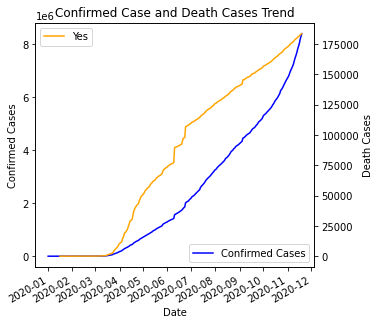

In [ ]:
#https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf
# check the death cases/ confirmed case trend

# cumulative death and confirmed cases
# pd.crosstab(df.cdc_report_dt,df[df.death_yn=='Yes'].death_yn).cumsum().plot()
# pd.crosstab(df.cdc_report_dt,df.current_status).cumsum().plot()
death=pd.crosstab(df.cdc_report_dt,df[df.death_yn=='Yes'].death_yn).cumsum()
confirmed=pd.crosstab(df.cdc_report_dt,df.current_status).cumsum()
confirmed["Total confirmed case"] = confirmed.iloc[:,:2].sum(axis=1)


# plot for confirmed and death cases trend
fig0, ax0 = plt.subplots(figsize=(5,5))
ax1 = ax0.twinx()
confirmed["Total confirmed case"].plot(kind='line', ax=ax0, color = "blue", label = "Confirmed Cases")
death.plot(kind='line',ax=ax1, color = "orange", label = "Death Cases")
ax0.set_xlabel('Date')
ax0.set_ylabel("Confirmed Cases",fontsize=10)
ax1.set_ylabel("Death Cases",fontsize=10)
ax0.set_title('Confirmed Case and Death Cases Trend')
ax0.legend(loc="lower right")
ax1.legend(loc="upper left")
plt.show()

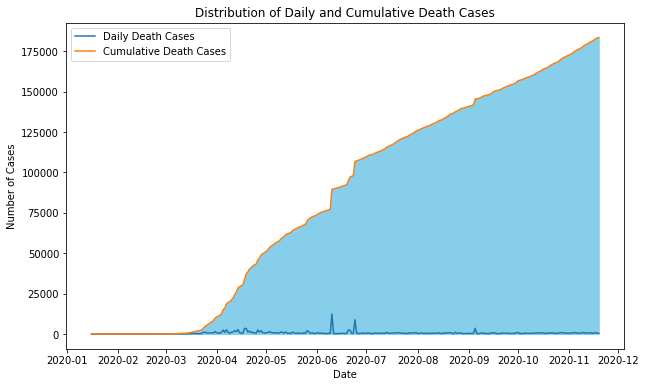

In [ ]:
# daily and cumulative death cases
daily_death = pd.crosstab(df.cdc_report_dt,df[df.death_yn=='Yes'].death_yn)
cumulative_death = pd.crosstab(df.cdc_report_dt,df[df.death_yn=='Yes'].death_yn).cumsum()


# plot for death cases trend
plt.figure(figsize = (10,6))
plt.plot(daily_death, label = "Daily Death Cases")
plt.fill_between(cumulative_death.index, cumulative_death["Yes"], color = "skyblue")
plt.plot(cumulative_death, label = "Cumulative Death Cases")
plt.title("Distribution of Daily and Cumulative Death Cases")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()

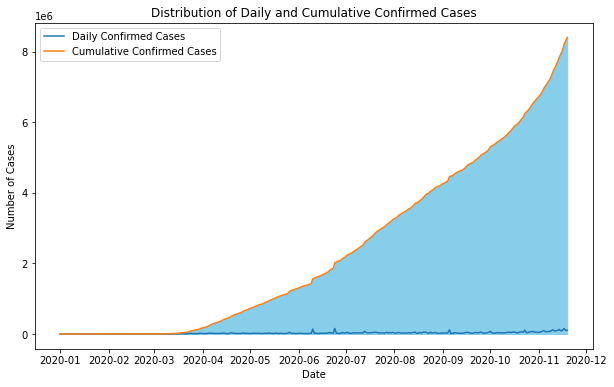

In [ ]:
# daily and cumulative confirmed cases
daily_confirmed = pd.crosstab(df.cdc_report_dt,df.current_status).sum(axis=1)
cumulative_confirmed = pd.crosstab(df.cdc_report_dt,df.current_status).cumsum().sum(axis=1)


# plot for confirmed cases trend
plt.figure(figsize = (10,6))
plt.plot(daily_confirmed, label = "Daily Confirmed Cases")
plt.fill_between(cumulative_confirmed.index, cumulative_confirmed.to_list(), color = "skyblue")
plt.plot(cumulative_confirmed, label = "Cumulative Confirmed Cases")
plt.title("Distribution of Daily and Cumulative Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()

## Death Rate

In [ ]:
#check the death rate
#death rate for Laboratory-confirmed case
rate_table=pd.concat([death,confirmed],join='inner',axis=1)
rate_table = rate_table.rename(columns = {"Yes": "Death case"})

lab_death_rate = rate_table["Death case"][-1]/rate_table['Laboratory-confirmed case'][-1]
print(f"Laboratory-confirmed death rate is: {lab_death_rate*100:.2f}%")

#death rate for Laboratory-confirmed case+Probable Case
total_death_rate = rate_table["Death case"][-1]/rate_table['Total confirmed case'][-1]
print(f"Total-confirmed death rate is: {total_death_rate*100:.2f}%")
#actual death rate by Nov 19th: confirmed  11768874, death 251715 (https://covid.cdc.gov/covid-data-tracker/?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fcases-updates%2Fcases-in-us.html#cases_casesper100klast7days)
print(f"Actual death rate is: {251715/11768874*100:.2f}%")

Laboratory-confirmed death rate is: 2.32%
Total-confirmed death rate is: 2.18%
Actual death rate is: 2.14%


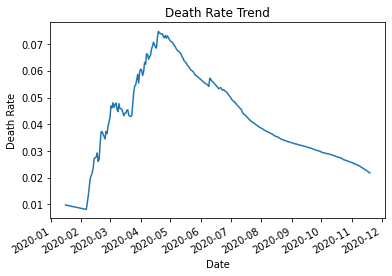

In [ ]:
#death rate over time
rate_table['death_rate']=rate_table.iloc[:,0]/rate_table.iloc[:,-1]
rate_table['death_rate'].plot()
plt.title("Death Rate Trend")
plt.xlabel('Date')
plt.ylabel('Death Rate')
plt.show()

In [ ]:
#death and hosp rate by age group
#https://www.statista.com/statistics/1122354/covid-19-us-hospital-rate-by-age/

pd.crosstab(df["age_group"],df['hosp_yn'],normalize='index')
pd.crosstab(df["age_group"],df['death_yn'],normalize='index')

death_yn,No,Yes
age_group,,
0 - 9 Years,0.999516,0.000484
10 - 19 Years,0.999657,0.000343
20 - 29 Years,0.998834,0.001166
30 - 39 Years,0.996336,0.003664
40 - 49 Years,0.990588,0.009412
50 - 59 Years,0.974850,0.025150
60 - 69 Years,0.925433,0.074567
70 - 79 Years,0.812003,0.187997
80+ Years,0.595556,0.404444


Text(0, 0.5, 'Hospitalization Rate')

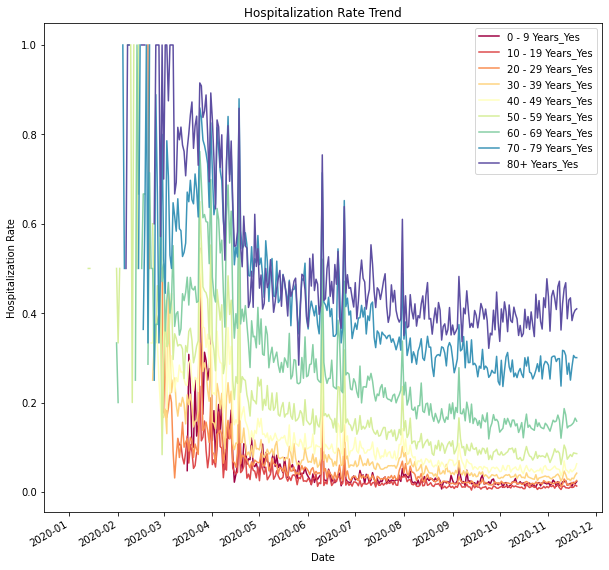

In [ ]:
hosp_age=df.groupby(['cdc_report_dt','age_group'])['hosp_yn'].value_counts(normalize=True).unstack(['age_group','hosp_yn'])
hosp_age.columns.droplevel(0)
hosp_age.columns = ["_".join(x) for x in hosp_age.columns.ravel()]
hosp_age=hosp_age.loc[:,['0 - 9 Years_Yes','10 - 19 Years_Yes','20 - 29 Years_Yes','30 - 39 Years_Yes','40 - 49 Years_Yes','50 - 59 Years_Yes','60 - 69 Years_Yes','70 - 79 Years_Yes','80+ Years_Yes']]

# Plotting
lines = hosp_age.plot.line(figsize=(10,10),cmap='Spectral', title='Hospitalization Rate Trend')
lines.set_xlabel("Date")
lines.set_ylabel("Hospitalization Rate")

In [ ]:
#death and hosp rate by Race and ethnicity (combined)
pd.crosstab(df["Race and ethnicity (combined)"],df['hosp_yn'],normalize='index')
pd.crosstab(df["Race and ethnicity (combined)"],df['death_yn'],normalize='index')

death_yn,No,Yes
Race and ethnicity (combined),,
"American Indian/Alaska Native, Non-Hispanic",0.934321,0.065679
"Asian, Non-Hispanic",0.932986,0.067014
"Black, Non-Hispanic",0.928736,0.071264
Hispanic/Latino,0.961694,0.038306
"Multiple/Other, Non-Hispanic",0.958875,0.041125
"Native Hawaiian/Other Pacific Islander, Non-Hispanic",0.971688,0.028312
"White, Non-Hispanic",0.939939,0.060061


In [ ]:
#death and hosp rate by sex
pd.crosstab(df["sex"],df['hosp_yn'],normalize='index')
pd.crosstab(df["sex"],df["death_yn"], normalize="index")

death_yn,No,Yes
sex,,
Female,0.958289,0.041711
Male,0.946063,0.053937


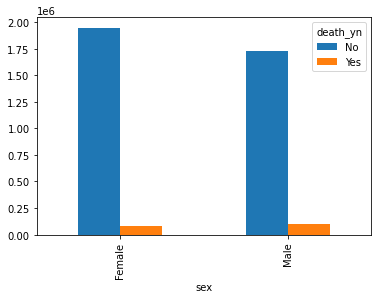

In [ ]:
pd.crosstab(df["sex"],df["death_yn"]).plot(kind="bar")

In [ ]:
pd.crosstab(df["sex"],df["death_yn"], normalize="index")["Yes"]

sex
Female    0.041711
Male      0.053937
Name: Yes, dtype: float64

In [ ]:
#death and hosp rate by medcond_yn
pd.crosstab(df["medcond_yn"],df['hosp_yn'],normalize='index')
pd.crosstab(df["medcond_yn"],df["death_yn"], normalize="index")

death_yn,No,Yes
medcond_yn,,
No,0.993593,0.006407
Yes,0.875977,0.124023


# Data Cleaning for NA

Dataset for model can handle nan values

In [ ]:
def missing_values_table(df):
    missing_val= df.isnull().sum()
    # Percentage of missing values
    missing_per = 100 * df.isnull().sum() / len(df)
    mis_values_table = pd.concat([missing_val,missing_per],axis=1)
    mis_values_table = mis_values_table.rename(columns={0 : 'Missing Values', 1 : 'Percentage of Missing Values'})
    mis_values_table = mis_values_table[mis_values_table.iloc[:,1] != 0].sort_values('Percentage of Missing Values', ascending=False).round(2)
    return mis_values_table

In [ ]:
missing_values_table(df)

,Missing Values,Percentage of Missing Values
icu_yn,7464517,88.81
medcond_yn,6901408,82.11
pos_spec_dt,5534290,65.84
death_yn,4530689,53.90
hosp_yn,4363752,51.92
onset_dt,4009122,47.70
Race and ethnicity (combined),3382702,40.25
sex,93590,1.11
age_group,32041,0.38


display missing values for death='yes'
                               Missing Values  Percentage of Missing Values
icu_yn                                 140507                         76.54
pos_spec_dt                            112836                         61.47
medcond_yn                             110531                         60.21
onset_dt                                87837                         47.85
hosp_yn                                 42654                         23.23
Race and ethnicity (combined)           31503                         17.16
sex                                       535                          0.29
age_group                                  22                          0.01
display missing values for death='no'
                               Missing Values  Percentage of Missing Values
icu_yn                                3000618                         81.30
medcond_yn                            2638483                         71.49
pos_spec_dt

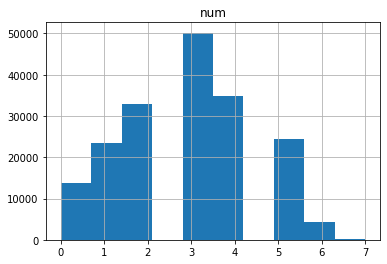

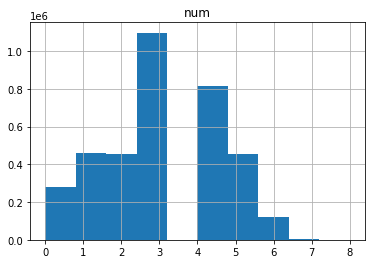

In [ ]:
#get datatable with nan values by death_yn='yes' or 'no'

print("display missing values for death='yes'")
# death = "yes" by row
death_nan_row = pd.DataFrame(data = df[df.death_yn=='Yes'].isnull().sum(axis=1), columns=['num'])
death_nan_row.hist()

# by columns
#pd.set_option("display.max_rows", None)
print(missing_values_table(df[df.death_yn=='Yes']))

print("display missing values for death='no'")
# death = "no" by row
alive_nan_row = pd.DataFrame(data = df[df.death_yn=='No'].isnull().sum(axis=1), columns=['num'])
alive_nan_row.hist()

# by columns
print(missing_values_table(df[df.death_yn=='No']))

In [ ]:
#keep the death_yn= 'yes' rows with less nan as much as possible
death_nan_row[death_nan_row.num <= 1].count()
death_index_list = death_nan_row[death_nan_row.num <= 1].index.to_list()
df_death_yes = df.iloc[death_index_list,:]

In [ ]:
df_death_yes.isna().sum()

In [ ]:
#keep the death_yn= 'No' with less nan
alive_nan_row[alive_nan_row.num <= 0].count()
alive_index_list = alive_nan_row[alive_nan_row.num <= 0].index.to_list()
df_death_no = df.iloc[alive_index_list,:]

In [ ]:
df_cleaned = df_death_yes.append(df_death_no)

In [ ]:
df_cleaned.death_yn.value_counts()

No     281215
Yes     37102
Name: death_yn, dtype: int64

# Derivative Data column

In [ ]:
#whether onset when test positive
df_cleaned["onset_pos"] = (df_cleaned["pos_spec_dt"] - df_cleaned['onset_dt']).astype('timedelta64[D]')
#onset > cdc_report: early treatment
df_cleaned["early_treatment"] = (df_cleaned["onset_dt"] - df_cleaned['cdc_report_dt']).astype('timedelta64[D]')
#print(df_cleaned["early_treatment"])
#df_cleaned[df_cleaned["early_treatment"] > 0].current_status.value_counts()
df_cleaned.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,onset_pos,early_treatment
349,2020-11-17,2020-11-10,2020-11-05,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",No,NaN,Yes,No,5.0,-12.0
1155,2020-11-17,2020-11-10,2020-11-05,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",No,NaN,Yes,No,5.0,-12.0
2956,2020-11-17,2020-11-10,2020-11-06,Laboratory-confirmed case,Male,10 - 19 Years,"White, Non-Hispanic",No,No,Yes,No,4.0,-11.0
3736,2020-11-17,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"White, Non-Hispanic",No,NaN,Yes,No,1.0,-8.0
4213,2020-11-17,2020-11-10,2020-11-08,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,No,Yes,No,2.0,-9.0


In [ ]:
df_cleaned=df_cleaned.iloc[:,3:]
cat_var=['current_status','sex','age_group','Race and ethnicity (combined)','hosp_yn','icu_yn','medcond_yn']
# df_cleaned= pd.get_dummies(df_cleaned, columns=cat_var)

In [ ]:
df_cleaned.to_csv('AN8005_cleaned.csv')


# Model Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, r2_score
from sklearn.model_selection import train_test_split

# data = pd.read_csv('/content/drive/MyDrive/AN8005/Group/AN8005_cleaned.csv',index_col=0) # Wu Di
data = pd.read_csv('/content/drive/MyDrive/Group/AN8005_cleaned.csv',index_col=0) # Cathy
data.reset_index(drop=True,inplace=True)
data.head()

,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,onset_pos,early_treatment
0,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",No,NaN,Yes,No,5.0,-12.0
1,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",No,NaN,Yes,No,5.0,-12.0
2,Laboratory-confirmed case,Male,10 - 19 Years,"White, Non-Hispanic",No,No,Yes,No,4.0,-11.0
3,Laboratory-confirmed case,Male,10 - 19 Years,"White, Non-Hispanic",No,NaN,Yes,No,1.0,-8.0
4,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,No,Yes,No,2.0,-9.0


In [ ]:
data_dummy = pd.get_dummies(data,columns = ['sex','current_status','age_group','Race and ethnicity (combined)','hosp_yn','icu_yn','medcond_yn'])
data_dummy.death_yn = (data_dummy.death_yn == 'Yes')*1
data_dummy.dropna(inplace=True)

## Only train set balance

In [ ]:
X = data_dummy.drop(columns='death_yn')
y = data_dummy['death_yn']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.06)
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
train = pd.merge(left=x_train,right=y_train,how='outer',left_index=True,right_index=True)
train.shape, x_test.shape

((285862, 29), (18247, 28))

In [ ]:
print('Original imbalanced dataset has y == 1: ',len(train[train['death_yn']==1]))
print('Original imbalanced dataset has y == 0: ',len(train[train['death_yn']==0]))
df_0 = train[train['death_yn']==0]
df_1 = train[train['death_yn']==1]
df_0_sample = df_0.sample(n=len(df_1),random_state=0)
df_final = df_0_sample.append(df_1)
from sklearn.utils import shuffle
train = shuffle(df_final)
train.reset_index(drop=True,inplace=True)
y_train = train.iloc[:,-1].to_numpy()
x_train = train.iloc[:,:-1].to_numpy()
print('balanced dataset has y == 1: ',len(y_train[y_train==1]))
print('balanced dataset has y == 0: ',len(y_train[y_train==0]))

Original imbalanced dataset has y == 1:  21502
Original imbalanced dataset has y == 0:  264360
balanced dataset has y == 1:  21502
balanced dataset has y == 0:  21502


In [ ]:
print('Trainset ratio:',y_train.shape[0] / (y_test.shape[0]+y_train.shape[0]))

Trainset ratio: 0.7020946596790256


## Logistic Regression

Trainset shape:  (43004, 28)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 0.8, 'max_iter': 500, 'penalty': 'l2'}
Accuracy for trainset: 0.9245186494279601
Accuracy for testset: 0.915712171863868


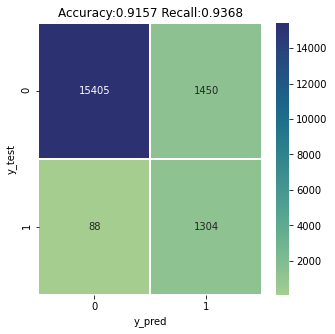

In [ ]:
logistic_classifier = linear_model.LogisticRegression(random_state=2020)

param_lr = {
              "C":list(np.arange(0,1.01,0.1)), 
              "penalty":["l1","l2"],
              "max_iter":[500]
              }

bst = GridSearchCV(logistic_classifier, param_lr, n_jobs=5, 
                   scoring = "accuracy", cv = 5, refit = True)

print('Trainset shape: ',x_train.shape)
bst.fit(x_train,y_train)

print(bst.best_params_)
y_pred = bst.predict(x_test)
cm_lr_test = confusion_matrix(y_test, y_pred)
score_lr_train = accuracy_score(bst.predict(x_train),y_train)
score_lr_test = accuracy_score(y_pred,y_test)
print(f'Accuracy for trainset: {score_lr_train}')
print(f'Accuracy for testset: {score_lr_test}')
recall_lr_score = recall_score(y_test,y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,5))
sns.heatmap(cm_lr_test, annot=True, linewidth=0.5, fmt='.0f', cmap='crest')
plt.title(f'Accuracy:{round(score_lr_test, 4)} Recall:{round(recall_lr_score,4)}')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

## Decision Tree

Accuracy for trainset: 0.9681069000838067
Accuracy for testset: 0.8998191483531539


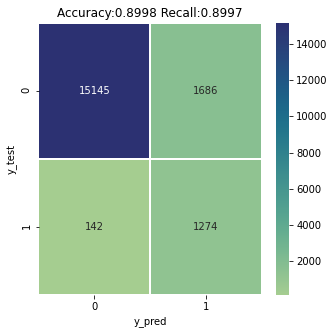

In [ ]:
# 1. build decision tree to the maximum
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

dt_classifier = DecisionTreeClassifier(random_state=2020)
dt_classifier = dt_classifier.fit(x_train, y_train)

# plot confusion matrix to display the accuracy
y_pred = dt_classifier.predict(x_test)
cm_dt_test = confusion_matrix(y_test,y_pred)
score_dt_train = accuracy_score(dt_classifier.predict(x_train),y_train)
score_dt_test = accuracy_score(y_pred,y_test)
print(f'Accuracy for trainset: {score_dt_train}')
print(f'Accuracy for testset: {score_dt_test}')
recall_dt_score = recall_score(y_test,y_pred)

accuracy = accuracy_score(y_test, y_pred) * 100
#print(f"Accuracy: {accuracy:.2f}%")

# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm_dt_test, annot=True, linewidth=0.5, fmt='.0f', cmap='crest')
plt.title(f'Accuracy:{round(score_dt_test, 4)} Recall:{round(recall_dt_score,4)}')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

# plot the tree
#tree.plot_tree(dt_classifier)

In [ ]:
depth_range = 20
test_error = []
train_error = []
# change the maximum depth from 1 to 20
for i in range(1, depth_range):
  classifier = DecisionTreeClassifier(random_state=2020,max_depth=i)
  classifier.fit(x_train, y_train)
  pred_test = classifier.predict(x_test)
  pred_train = classifier.predict(x_train)
  test_error.append(1-accuracy_score(pred_test, y_test))
  train_error.append(1-accuracy_score(pred_train, y_train))

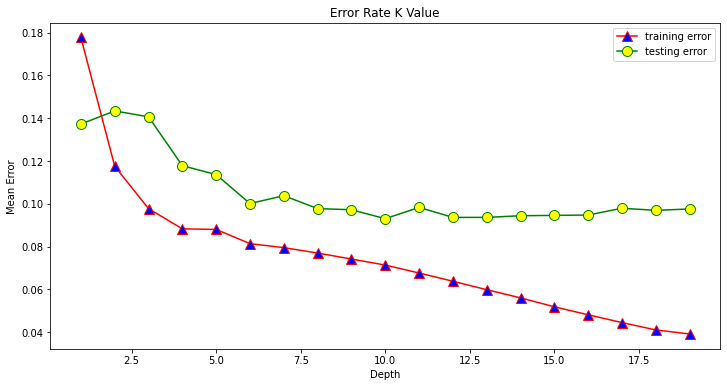

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1, depth_range),train_error, color='red', marker='^',
         markerfacecolor = 'blue', markersize=10, label='training error')
plt.plot(range(1, depth_range), test_error, color='green', marker='o',
         markerfacecolor = 'yellow', markersize=10, label='testing error')
plt.title('Error Rate K Value')
plt.xlabel('Depth')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

In [ ]:
sample_leaf_range = 20
test_error = []
train_error = []
# change the maximum depth from 1 to 20
for i in range(1, depth_range):
  classifier = DecisionTreeClassifier(random_state=2020,min_samples_leaf=i)
  classifier.fit(x_train, y_train)
  pred_test = classifier.predict(x_test)
  pred_train = classifier.predict(x_train)
  test_error.append(1-accuracy_score(pred_test, y_test))
  train_error.append(1-accuracy_score(pred_train, y_train))

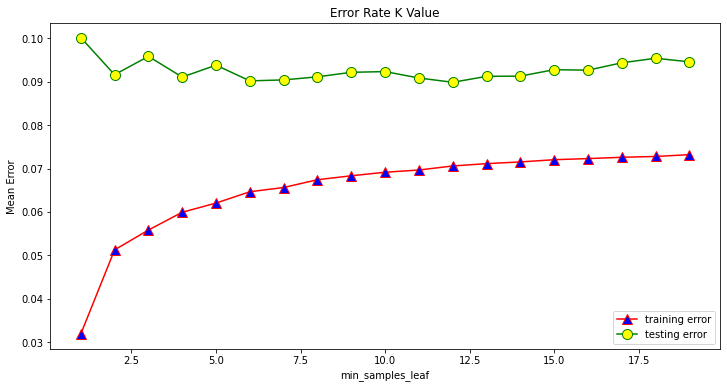

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1, depth_range),train_error, color='red', marker='^',
         markerfacecolor = 'blue', markersize=10, label='training error')
plt.plot(range(1, depth_range), test_error, color='green', marker='o',
         markerfacecolor = 'yellow', markersize=10, label='testing error')
plt.title('Error Rate K Value')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

Accuracy for trainset: 0.9265294720178787
Accuracy for testset: 0.9075464459911218


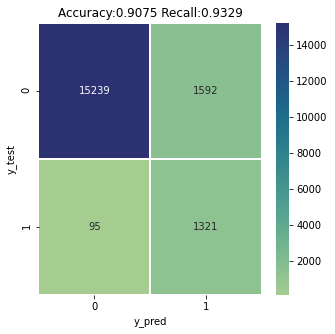

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=2020, max_depth=10,min_samples_leaf=6)
dt_classifier = dt_classifier.fit(x_train, y_train)

# plot confusion matrix to display the accuracy
y_pred = dt_classifier.predict(x_test)
cm_dt_test = confusion_matrix(y_test,y_pred)
score_dt_train = accuracy_score(dt_classifier.predict(x_train),y_train)
score_dt_test = accuracy_score(y_pred,y_test)
print(f'Accuracy for trainset: {score_dt_train}')
print(f'Accuracy for testset: {score_dt_test}')
recall_dt_score = recall_score(y_test,y_pred)

accuracy = accuracy_score(y_test, y_pred) * 100
#print(f"Accuracy: {accuracy:.2f}%")

# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm_dt_test, annot=True, linewidth=0.5, fmt='.0f', cmap='crest')
plt.title(f'Accuracy:{round(score_dt_test, 4)} Recall:{round(recall_dt_score,4)}')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

## Random Forest

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 500}
Accuracy for trainset: 0.9122155132373433
Accuracy for testset: 0.886775908368499


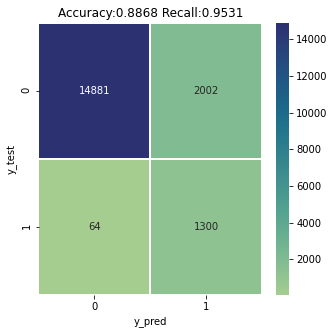

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_params = [{
    'max_depth' : list(range(3,7,1)),
    'criterion' : ['gini','entropy'],
    'n_estimators': [500]}]
GS_rf = GridSearchCV(RandomForestClassifier(random_state=2020), rf_params, scoring = "accuracy", cv = 5, refit = True)
GS_rf.fit(x_train, y_train)

print(GS_rf.best_params_)
y_pred = GS_rf.predict(x_test)
cm_rf_test = confusion_matrix(y_test, y_pred)
score_rf_train = accuracy_score(GS_rf.predict(x_train),y_train)
score_rf_test = accuracy_score(y_pred,y_test)
print(f'Accuracy for trainset: {score_rf_train}')
print(f'Accuracy for testset: {score_rf_test}')
recall_rf_score = recall_score(y_test,y_pred)

import seaborn as sns

plt.figure(figsize=(5,5))
sns.heatmap(cm_rf_test, annot=True, linewidth=0.5, fmt='.0f', cmap='crest')
plt.title(f'Accuracy:{round(score_rf_test, 4)} Recall:{round(recall_rf_score,4)}')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

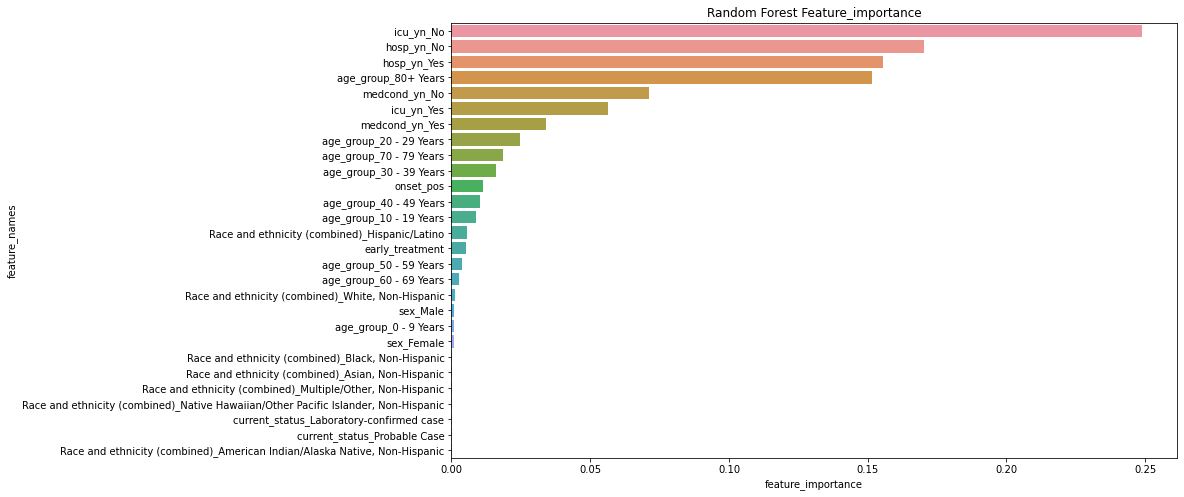

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names):

    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':importance}
    featureimportance_df = pd.DataFrame(data).sort_values(by=['feature_importance'], ascending=False)
    featureimportance_df_filter = featureimportance_df.iloc[:30,:]
    plt.figure(figsize=(13,8))
    sns.barplot(x=featureimportance_df_filter['feature_importance'], y=featureimportance_df_filter['feature_names'])
    plt.title('Random Forest Feature_importance')
    plt.xlabel('feature_importance')
    plt.ylabel('feature_names')
    plt.show()

# plot_feature_importance(model3.feature_importances_,x.columns)
plot_feature_importance(GS_rf.best_estimator_.feature_importances_,X.columns)
plt.show()

## SVC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {"C":[0.1,1],"kernel": ['linear','poly','rbf','sigmoid']}
grid = GridSearchCV(SVC(), param_grid, scoring='accuracy')
grid.fit(x_train,y_train)

y_pred = grid.best_estimator_.predict(x_test)

In [ ]:
print(grid.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Precision: 0.43517587939698493
Recall: 0.9232409381663113
Accuracy 0.9016824683509618


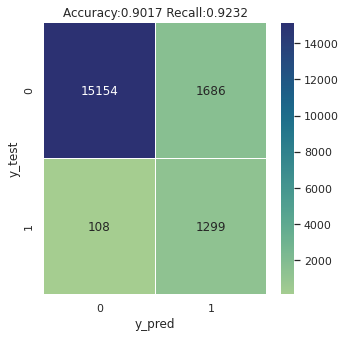

In [ ]:
clf = SVC(C=1, kernel='rbf')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
cm_svc_test = confusion_matrix(y_test, y_pred)
score_svc_train = accuracy_score(clf.predict(x_train),y_train)
score_svc_test = accuracy_score(y_pred,y_test)

from sklearn import metrics
# Model Prediction: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("Accuracy", metrics.accuracy_score(y_test, y_pred))


plt.figure(figsize=(5,5))
sns.heatmap(cm_svc_test, annot=True, linewidth=0.5, fmt='.0f', cmap='crest')
plt.title(f'Accuracy:{round(score_svc_test, 4)} Recall:{round(metrics.recall_score(y_test, y_pred),4)}')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

# Build from scratch

## Logistic Regression

logistic regression is as following
> `equation 1`
>
>$\hat{y}=g(z)=\frac{1}{1+e^{-\textbf{z}}}$

where

>`equation 2`
> 
> $\textbf{z} = \textbf{w}·\textbf{x}$ 

Here, we are using cross entropy as the cost function

>`equation 3`
>
>$Entropy(t) = -\underset{j}{\sum}{p(j|t)}$



In [ ]:
import numpy as np
from tqdm import trange


class LogisticRegression:
    

    @staticmethod
    def sigmoid(z:float)->float:
        """
        a simple function for returning sigmoid result

        Parameters
        ----------
        z : float
            the number to put in sigmoid
        
        Returns
        -------
        the sigmoid result
        """
        return (1 + (np.e)**(-z))**(-1)
    

    def cost_function(self, X, weights, y)->float:
        y_hat = LogisticRegression.sigmoid(np.dot(X, weights))

        predict_0 = (1-y) * np.log2(1-y_hat)
        predict_1 = y * np.log2(y_hat)

        loss = -sum(predict_0, predict_1)
        l2_penalty = sum(weights**2)/2

        return (loss+l2_penalty)/len(X)

    
    def fit(self, X, y, epochs:int=1000, learning_rate:float=0.05, l2_penalty_ratio:float=0.9)->None:
        loss = list()
        weights = np.random.rand(X.shape[1])

        for _ in trange(epochs):
          # Gradient Descent
          y_hat = LogisticRegression.sigmoid(np.dot(X, weights))
          gradient = (np.dot(X.T, y_hat - y)/np.log(2) + l2_penalty_ratio*weights)
          weights -= learning_rate * gradient / len(X)
          loss.append(self.cost_function(X, weights, y))
        
        self.weights = weights
        self.loss = loss


    def predict(self, X)->None:
        if self.weights is None:
          raise ModelUnfittedExcepetion
        s = LogisticRegression.sigmoid
        return [1 if y_hat>0.5 else 0 for y_hat in s(np.dot(X, self.weights))]
    

    def plot_loss(self)->None:
        print(self.loss)
        sns.lineplot(self.loss)
        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 1000/1000 [13:46<00:00,  1.21it/s]


Accuracy for trainset: 0.9057994605153009
Accuracy for testset: 0.90475146599441


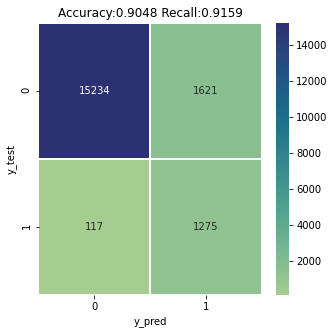

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
our_model = LogisticRegression()
our_model.fit(x_train, y_train)
y_pred = our_model.predict(x_test)
cm_lr_test = confusion_matrix(y_test, y_pred)
score_lr_train = accuracy_score(our_model.predict(x_train),y_train)
score_lr_test = accuracy_score(y_pred,y_test)
print(f'Accuracy for trainset: {score_lr_train}')
print(f'Accuracy for testset: {score_lr_test}')
recall_lr_score = recall_score(y_test,y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm_lr_test, annot=True, linewidth=0.5, fmt='.0f', cmap='crest')
plt.title(f'Accuracy:{round(score_lr_test, 4)} Recall:{round(recall_lr_score,4)}')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()